In [5]:
import os
import random
import re
import jieba
import warnings
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [11]:
os.chdir('D:\\corpus')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

'''
part-0: 调整超参数
'''
my_lr = 1e-2
my_test_size = 0.1
my_validation_split = 0.1
my_epochs = 3 #40
my_batch_size = 128
my_dropout = 0.2

my_optimizer = Nadam(lr=my_lr)
my_loss = 'binary_crossentropy'

In [12]:
'''
part-A: 数据探索
'''
print('\npart-A: 数据探索')

# 将已经分类好的每条评论的路径放进列表
pos_txts = os.listdir('res\\datanew\\pos')
neg_txts = os.listdir('res\\datanew\\neg')

# print('num of pos: {0}'.format(len(pos_txts))) # pos样本个数 2000
# print('num of neg: {0}'.format(len(neg_txts))) # neg样本个数 2000

# # 随机展示5条pos文本
# pos_samples = random.sample(pos_txts, 5)
# for item in pos_samples:
#     with open(os.path.join('res\\datanew\\pos', item), 'r', encoding='utf-8') as f:
#         s = f.read()
#         print(item)
#         print(s)

# 将所有的评论内容放置到一个list里，列表中的每个元素是一条评论
train_texts_orig = [] 
for i in range(len(pos_txts)):
    with open('res\\datanew\\pos\\'+pos_txts[i], 'r', errors='ignore', encoding='UTF-8') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('res\\datanew\\neg\\'+neg_txts[i], 'r', errors='ignore', encoding='UTF-8') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
# print('num of all in list: {0}'.format(len(train_texts_orig))) # list长度 4000


part-A: 数据探索


In [13]:

'''
part-B: 数据预处理-分词
'''
print('\npart-B: 数据预处理-分词')

# 使用gensim加载已经训练好的汉语词向量#sgns.zhihu.bigram.bz2
cn_model = KeyedVectors.load_word2vec_format('res\\word-vector\\sgns.zhihu.bigram.bz2', binary=False)

# 用jieba进行中文分词，最后将每条评论转换为了词索引的列表
train_tokens = []
for text in train_texts_orig:
    # 分词前去掉标点和特殊符号
    text = re.sub("[\s+\.\!\/_,-|$%^*(+\"\')]+|[+——！，； 。？ 、~@#￥%……&*（）]+", "", text)
    cut = jieba.cut(text)
    cut_list = [i for i in cut]
    for i, word in enumerate(cut_list):
        try:
            # 将分出来的每个词转换为词向量中的对应索引
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            # 如果词不在词向量中，则索引标记为0
            cut_list[i] = 0
    train_tokens.append(cut_list)
print('num of train_tokens: {0}'.format(len(train_tokens))) # 4000


part-B: 数据预处理-分词


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\user27\AppData\Local\Temp\jieba.cache
Loading model cost 0.944 seconds.
Prefix dict has been built successfully.


num of train_tokens: 4000


In [ ]:
import pandas as pd
path='D:\\Github\\Chinese-corpus-sentiment-data-analysis\\data.csv'
#通过open操作中转一下（应该是转换成python内置的文件流了）
o=open(path,'rb')
f=pd.read_csv(o)
o.close
f
f.shape
list(f["内容"])

In [14]:
'''
part-C: 数据预处理-索引化
'''
print('\npart-C: 数据预处理-索引化')

# 获得每条评论的长度，即分词后词语的个数，并将列表转换为ndarray格式
num_tokens = [len(tokens) for tokens in train_tokens]
num_tokens = np.array(num_tokens)

# print('max-len of train_tokens: {0}'.format(np.max(num_tokens)))  # 最长评价的长度 1438
# print('mean-len of train_tokens: {0}'.format(np.mean(num_tokens)))  # 平均评论的长度 68.77625

# # 绘制评论长度直方图
# plt.hist(np.log(num_tokens), bins = 100)
# plt.xlim((0,10))
# plt.ylabel('num of train_tokens')
# plt.xlabel('len of train_tokens')
# plt.show()

# 每段评语的长度不一，需要将索引长度标准化
mid_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
mid_tokens = int(mid_tokens)
rate = np.sum( num_tokens < mid_tokens ) / len(num_tokens)
# print('selected mid-len of train_tokens: {0}'.format(mid_tokens)) # 选取一个平均值，尽可能多的覆盖
# print('cover rate: {0}'.format(rate)) # 覆盖率


part-C: 数据预处理-索引化


In [16]:
'''
part-D: 数据预处理-重新构建词向量
'''
print('\npart-D: 数据预处理-重新构建词向量')

# print('num of vector: {0}'.format(len(cut_list))) # 预训练的词向量词汇数

# 为了节省训练时间，抽取前50000个词构建新的词向量
num_words = 50000 
embedding_dim = 300

# 初始化embedding_matrix，之后在keras上进行应用
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵，维度为 50000 * 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')

# # 检查新构建的词向量与预训练的词向量index是否对应
# print(cn_model[cn_model.index_to_key[10]])
# print(embedding_matrix[10])
# np.sum(cn_model[cn_model.index_to_key[10]] == embedding_matrix[10] ) # 300

# 新建词向量的维度，keras会用到
embedding_matrix.shape # (50000, 300)





part-D: 数据预处理-重新构建词向量


(50000, 300)

In [17]:
'''
part-E: 数据预处理-填充与裁剪
'''
print('\npart-E: 数据预处理-填充与裁剪')

# 输入的train_tokens是一个list，返回的train_pad是一个numpy array，采用pre填充的方式
train_pad = pad_sequences(train_tokens, maxlen=mid_tokens, padding='pre', truncating='pre')

# 超出五万个词向量的词用0代替
train_pad[train_pad>=num_words] = 0

# 准备实际输出结果向量向量，前2000好评的样本设为1，后2000差评样本设为0
train_target = np.concatenate((np.ones(2000),np.zeros(2000)))


part-E: 数据预处理-填充与裁剪


In [18]:
'''
part-F: 训练
'''
print('\npart-F: 训练')

# 用sklearn分割训练集、测试集
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=my_test_size, random_state=12)

# # 查看训练样本
# # 用索引反向生成语句，索引为零的标记为空格字符
# def reverse_tokens(tokens):
#     text = ''
#     for i in tokens:
#         if i != 0:
#             text = text + cn_model.index_to_key[i]
#         else:
#             text = text + ' '
#     return text
# print(reverse_tokens(X_train[66]))
# print('pred: ',y_train[66])

# 搭建神经网络
model = Sequential()

model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=mid_tokens, trainable=False))
model.add(Bidirectional(LSTM(units=32, dropout=my_dropout, return_sequences=True)))
model.add(LSTM(units=16, dropout=my_dropout, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=my_loss, optimizer=my_optimizer, metrics=['accuracy'])

# # 查看模型的结构
model.summary()



part-F: 训练
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 227, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 227, 64)           85248     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,090,449
Trainable params: 90,449
Non-trainable params: 15,000,000
_________________________________________________________________



part-G: 调试
Train on 3240 samples, validate on 360 samples
Epoch 1/3
3240/3240 [==============================] - 21s 6ms/step - loss: 0.6285 - accuracy: 0.6429 - val_loss: 0.5642 - val_accuracy: 0.7194

Epoch 00001: val_loss improved from inf to 0.56422, saving model to tmp\weights.hdf5
Epoch 2/3
3240/3240 [==============================] - 18s 6ms/step - loss: 0.4252 - accuracy: 0.8164 - val_loss: 0.3204 - val_accuracy: 0.8833

Epoch 00002: val_loss improved from 0.56422 to 0.32040, saving model to tmp\weights.hdf5
Epoch 3/3
3240/3240 [==============================] - 18s 6ms/step - loss: 0.3147 - accuracy: 0.8756 - val_loss: 0.2822 - val_accuracy: 0.8917

Epoch 00003: val_loss improved from 0.32040 to 0.28218, saving model to tmp\weights.hdf5


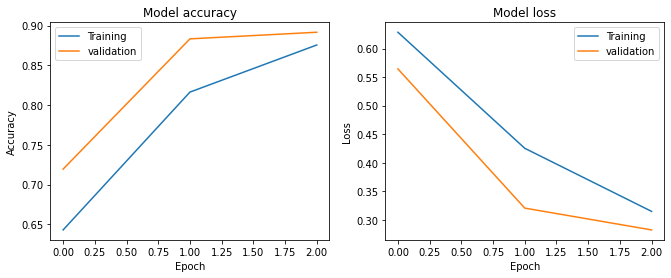

In [19]:
'''
part-G: 调试
'''
print('\npart-G: 调试')

# 建立一个权重的存储点，保存训练中的最好模型
path_checkpoint = 'tmp\\weights.hdf5'
checkpointer = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss' , verbose=1 , save_weights_only=True , save_best_only=True)

# # 尝试加载已训练模型
# try:
#     model.load_weights(path_checkpoint)
# except Exception as e:
#     print(e)

# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-5, patience=0, verbose=1)

# 定义callback函数
callbacks = [earlystopping, checkpointer, lr_reduction]

# 开始训练
history = model.fit(X_train, y_train, validation_split=my_validation_split, epochs=my_epochs, batch_size=my_batch_size, callbacks=callbacks)

# 模型可视化-历史
plt.figure(figsize=(11, 4))

plt.figure(1)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'validation'])

plt.figure(1)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'validation'])

plt.show()

In [23]:
# 模型可视化-RNN
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='tmp\\model.png')

# 模型评估-准确率
result = model.evaluate(X_test, y_test, verbose=0)
print('Loss: {0:.4}'.format(result[0]))
print('Accuracy: {0:.4%}'.format(result[1]))


Loss: 0.3275
Accuracy: 87.5000%
